In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#os.getcwd()
df=pd.read_csv("FAOSTAT_data - FAOSTAT_data_en_12-29-2024.csv")

In [18]:
# Filter relevant rows for Area harvested, Yield, Production
elements = ["Area harvested", "Yield", "Production"]
df_temp = df[df['Element'].isin(elements)]

# Pivot to wide format
df_pivot = df_temp.pivot_table(index=['Area', 'Item', 'Year'], 
                          columns='Element', 
                          values='Value').reset_index()

columns_rename = {
    'Area harvested': 'Area_Harvested',
    'Yield': 'Yield',
    'Production': 'Production'
}
df_pivot.rename(columns=columns_rename, inplace=True)

# Drop missing values
df_pivot.dropna(subset=['Area_Harvested', 'Yield', 'Production'], inplace=True)

# Encode categorical variables
le_area = LabelEncoder()
le_item = LabelEncoder()
df_pivot['Area_Code'] = le_area.fit_transform(df_pivot['Area'])
df_pivot['Item_Code'] = le_item.fit_transform(df_pivot['Item'])

# Save encoders
joblib.dump(le_area, 'le_area.pkl')
joblib.dump(le_item, 'le_item.pkl')


['le_item.pkl']

In [19]:
# Handle Duplicate Rows
print(df_pivot.duplicated().sum())

0


In [20]:
print(df_pivot.shape)
print(df_pivot.head())

(44981, 8)
Element         Area               Item  Year  Area_Harvested  Production  \
0        Afghanistan  Almonds, in shell  2019         29203.0     38205.0   
1        Afghanistan  Almonds, in shell  2020         22134.0     39307.0   
2        Afghanistan  Almonds, in shell  2021         36862.0     64256.0   
3        Afghanistan  Almonds, in shell  2022         36462.0     63515.0   
4        Afghanistan  Almonds, in shell  2023         37000.0     67000.0   

Element   Yield  Area_Code  Item_Code  
0        1308.3          0          2  
1        1775.9          0          2  
2        1743.2          0          2  
3        1742.0          0          2  
4        1810.8          0          2  


In [21]:
print(df['Item'].nunique())

276


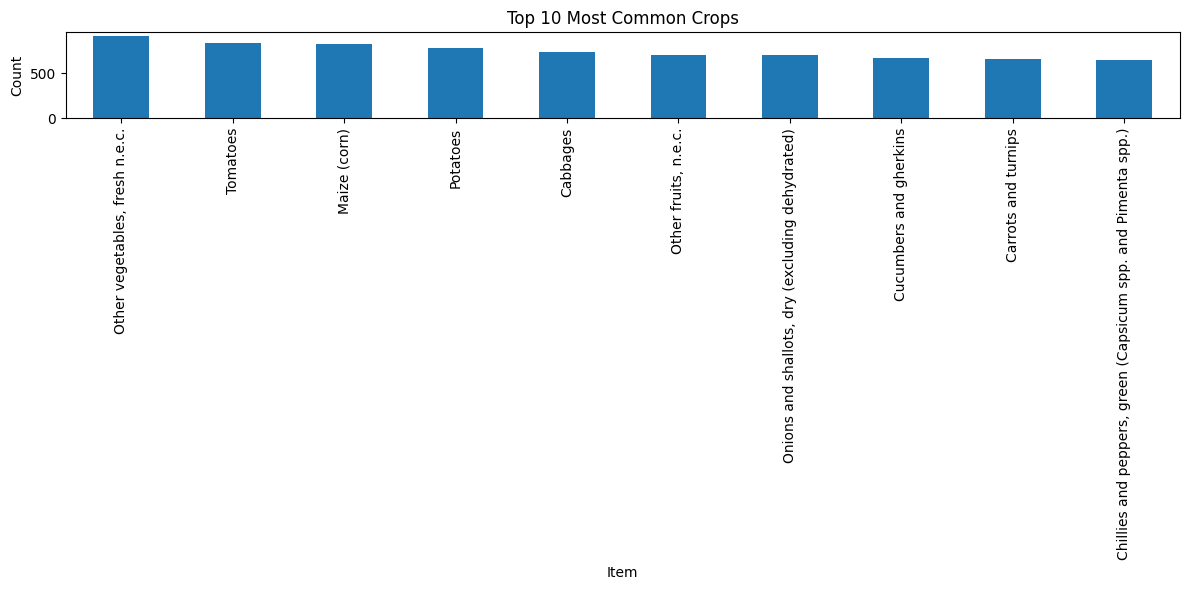

In [22]:
# 2. Exploratory Data Analysis (EDA)
# Crop Types Distribution
plt.figure(figsize=(12, 6))
df_pivot['Item'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Most Common Crops")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

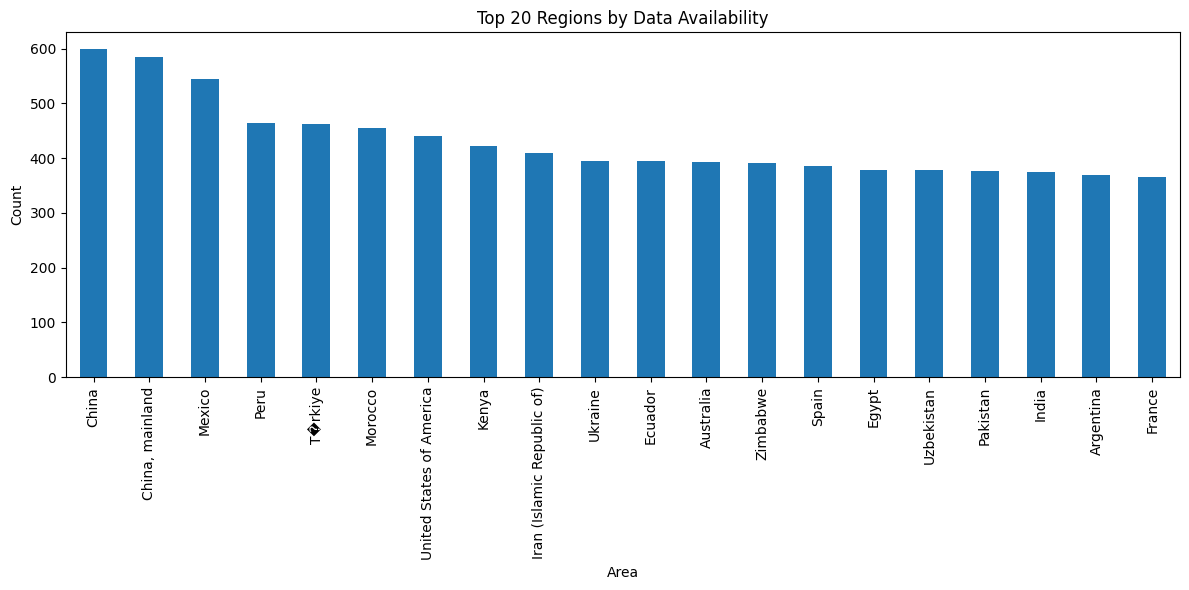

In [23]:
# Geographical Distribution
plt.figure(figsize=(12, 6))
df_pivot['Area'].value_counts().head(20).plot(kind='bar')
plt.title("Top 20 Regions by Data Availability")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

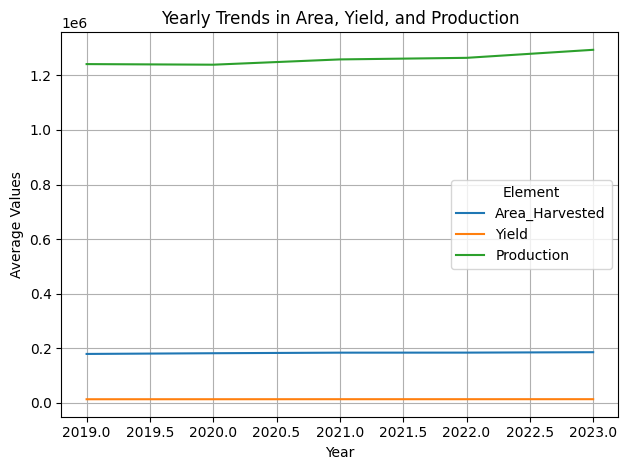

In [24]:
# Yearly Trends
plt.figure(figsize=(12, 6))
df_pivot.groupby('Year')[['Area_Harvested', 'Yield', 'Production']].mean().plot()
plt.title("Yearly Trends in Area, Yield, and Production")
plt.ylabel("Average Values")
plt.grid()
plt.tight_layout()
plt.show()

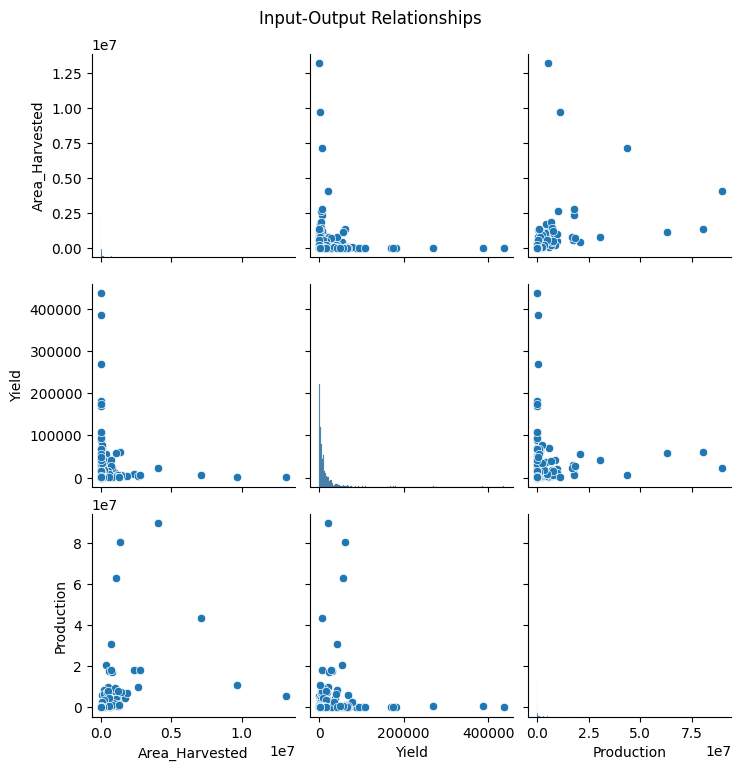

In [25]:
# Correlation between Area, Yield, and Production
sns.pairplot(df_pivot[['Area_Harvested', 'Yield', 'Production']].sample(1000, random_state=42))
plt.suptitle("Input-Output Relationships", y=1.02)
plt.show()

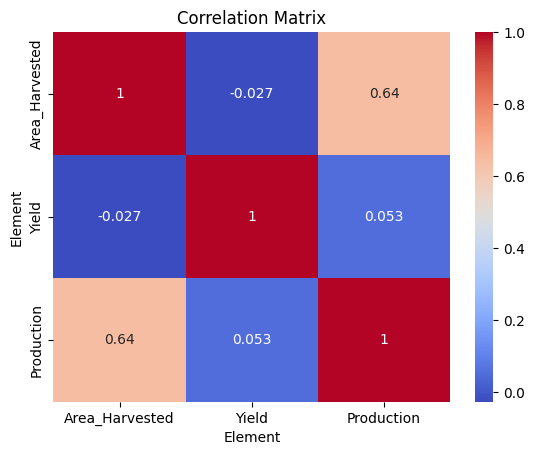

In [26]:
# Heatmap
sns.heatmap(df_pivot[['Area_Harvested', 'Yield', 'Production']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

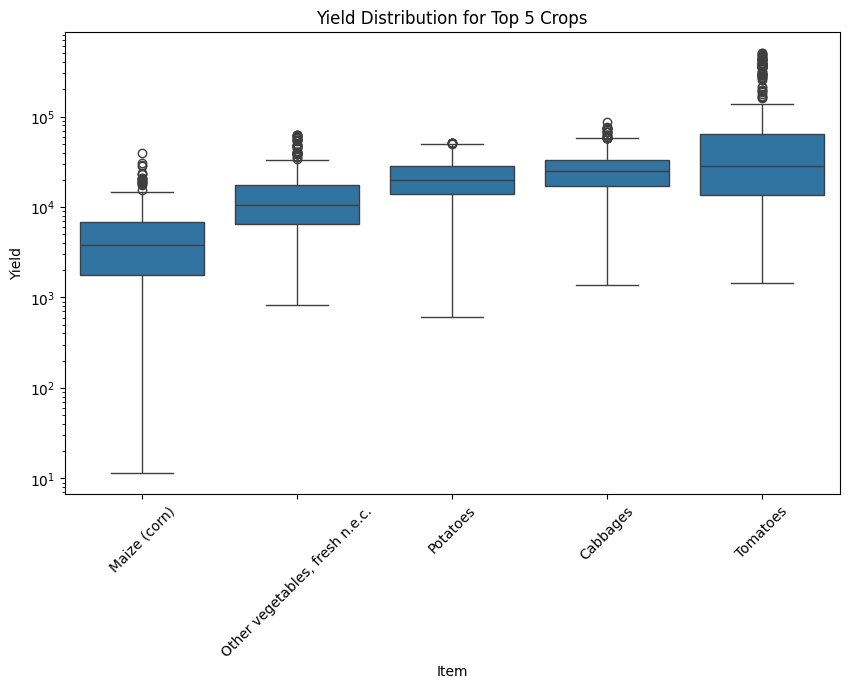

In [27]:
top_crops = df_pivot['Item'].value_counts().head(5).index
filtered_df = df_pivot[df_pivot['Item'].isin(top_crops)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='Item', y='Yield', data=filtered_df)
plt.xticks(rotation=45)
plt.yscale('log')
plt.title("Yield Distribution for Top 5 Crops")
plt.show()


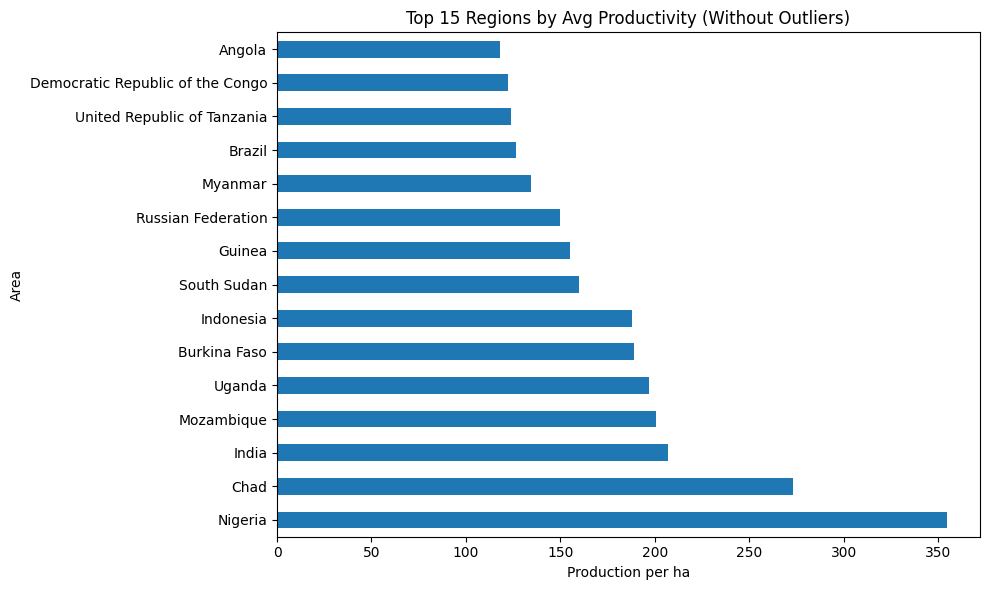

In [28]:

# Remove extremely high productivity values (e.g., top 1%)
df_pivot['Productivity']=df_pivot['Area_Harvested']/df_pivot['Yield']
threshold = df_pivot['Productivity'].quantile(0.99)
df_filtered = df_pivot[df_pivot['Productivity'] < threshold]

top_areas = df_filtered.groupby('Area')['Productivity'].mean().sort_values(ascending=False).head(15)
top_areas.plot(kind='barh', figsize=(10, 6), title="Top 15 Regions by Avg Productivity (Without Outliers)")
plt.xlabel("Production per ha")
plt.tight_layout()
plt.show()

In [29]:
# Feature selection
features = ['Area_Code', 'Item_Code', 'Year', 'Area_Harvested', 'Yield']
X = df_pivot[features]
y = df_pivot['Production']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler.pkl')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "SVM": SVR(kernel='rbf')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        'R2': r2_score(y_test, preds),
        'MSE': mean_squared_error(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds)
    }
    print(f"{name}: R2={results[name]['R2']:.3f}, MSE={results[name]['MSE']:.2f}, MAE={results[name]['MAE']:.2f}")

# Select best model on R2
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
best_model = models[best_model_name]
best_model.fit(X_scaled, y)
joblib.dump(best_model, 'model.pkl')
print(f"\nBest Model: {best_model_name}")

Linear Regression: R2=0.396, MSE=81337696673932.41, MAE=1190368.93
Lasso: R2=0.396, MSE=81337696478815.28, MAE=1190368.84
Ridge: R2=0.396, MSE=81337370944284.17, MAE=1190358.28
ElasticNet: R2=0.399, MSE=80920706204366.58, MAE=1176256.59
SVM: R2=-0.010, MSE=136005610752926.75, MAE=1171369.01

Best Model: ElasticNet


In [30]:
os.getcwd()

'd:\\Anaconda\\Project\\Project_II'

In [33]:
# Top Crops Plot
plt.figure(figsize=(10, 6))
df_pivot['Item'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Cultivated Crops")
plt.ylabel("Count")
plt.xlabel("Crop")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("top_crops.png")
plt.close()

# Top Regions Plot
plt.figure(figsize=(10, 6))
df_pivot['Area'].value_counts().head(20).plot(kind='bar', color='lightgreen')
plt.title("Top 20 Regions by Data Availability")
plt.ylabel("Count")
plt.xlabel("Region")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("top_regions.png")
plt.close()